In [1]:
import glob
import re
import matplotlib as plt
import numpy as np
import scipy as sp
import xarray as xr
import intake
import intake_esm
import pandas as pd

In [2]:
######## File paths ################
lustre_scratch    = "/lustre/desc1/scratch/harshah"
gdex_data         = "/gdex/data/special_projects/pythia_2024"
annual_means      =  gdex_data + '/annual_means/'
zarr_path         =  gdex_data + "/tas_zarr/"
#########
gdex_url           = 'https://data.gdex.ucar.edu/'
era5_catalog      = gdex_url + 'special_projects/pythia_2024/pythia_intake_catalogs/era5_catalog.json'
#
##########
print(era5_catalog)

https://data.gdex.ucar.edu/special_projects/pythia_2024/pythia_intake_catalogs/era5_catalog.json


In [3]:
USE_PBS_SCHEDULER = True

In [4]:
# Create a PBS cluster object
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(
        job_name = 'dask-osdf-24',
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = lustre_scratch + '/dask/spill',
        log_directory = lustre_scratch + '/dask/logs/',
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        walltime = '3:00:00',
        #interface = 'ib0'
        interface = 'ext'
    )
    return cluster

def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=4)
    return cluster

def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster, performance_report
    cluster = LocalCluster()    

    cluster.scale(6)
    return cluster

In [5]:
# Obtain dask cluster in one of three ways
if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41997 instead
  warnings.warn(


In [6]:
# Scale the cluster and display cluster dashboard URL
n_workers =5
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(b2bfc299, 'tcp://128.117.208.96:37075', workers=5, threads=5, memory=20.00 GiB)

In [7]:
%pip show intake-esm

Name: intake-esm
Version: 2025.2.3
Summary: An intake plugin for parsing an Earth System Model (ESM) catalog and loading netCDF files and/or Zarr stores into Xarray datasets.
Home-page: https://intake-esm.readthedocs.io
Author: 
Author-email: 
License: Apache Software License 2.0
Location: /glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages
Requires: dask, fastprogress, fsspec, intake, netCDF4, pandas, pydantic, requests, xarray, zarr
Required-by: ecgtools
Note: you may need to restart the kernel to use updated packages.


In [8]:
era5_cat = intake.open_esm_datastore(era5_catalog)
era5_cat

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/intake_esm/cat.py:250: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,unique
era_id,1
datatype,2
level_type,1
step_type,7
table_code,4
param_code,164
variable,212
long_name,212
units,33
year,85


In [9]:
era5_cat.df

,era_id,datatype,level_type,step_type,table_code,param_code,variable,long_name,units,year,month,format,frequency,path
0,e5,an,NaN,pl,128,60,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,1,nc,hourly,https://data.rda.ucar.edu/d633000/e5.oper.an.p...
1,e5,an,NaN,pl,128,60,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,1,nc,hourly,https://data.rda.ucar.edu/d633000/e5.oper.an.p...
2,e5,an,NaN,pl,128,60,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,1,nc,hourly,https://data.rda.ucar.edu/d633000/e5.oper.an.p...
3,e5,an,NaN,pl,128,60,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,1,nc,hourly,https://data.rda.ucar.edu/d633000/e5.oper.an.p...
4,e5,an,NaN,pl,128,60,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,1,nc,hourly,https://data.rda.ucar.edu/d633000/e5.oper.an.p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785063,e5,fc,sfc,minmax,128,202,MN2T,Minimum temperature at 2 metres since previous...,K,2024,1,nc,hourly,https://data.rda.ucar.edu/d633000/e5.oper.fc.s...
785064,e5,fc,sfc,minmax,228,226,MXTPR,Maximum total precipitation rate since previou...,kg m**-2 s**-1,2024,1,nc,hourly,https://data.rda.ucar.edu/d633000/e5.oper.fc.s...
785065,e5,fc,sfc,minmax,228,226,MXTPR,Maximum total precipitation rate since previou...,kg m**-2 s**-1,2024,1,nc,hourly,https://data.rda.ucar.edu/d633000/e5.oper.fc.s...
785066,e5,fc,sfc,minmax,228,227,MNTPR,Minimum total precipitation rate since previou...,kg m**-2 s**-1,2024,1,nc,hourly,https://data.rda.ucar.edu/d633000/e5.oper.fc.s...


In [10]:
temp_cat = era5_cat.search(variable='VAR_2T',frequency = 'hourly',year=2000)
temp_cat

,unique
era_id,1
datatype,1
level_type,0
step_type,1
table_code,1
param_code,1
variable,1
long_name,1
units,1
year,1


In [11]:
# Define the xarray_open_kwargs with a compatible engine, for example, 'scipy'
xarray_open_kwargs = {
    'engine': 'h5netcdf',
    'chunks': {},  # Specify any chunking if needed
    'backend_kwargs': {}  # Any additional backend arguments if required
}

In [12]:
%%time
dset_temp = temp_cat.to_dataset_dict(xarray_open_kwargs=xarray_open_kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'datatype.step_type'


CPU times: user 2.21 s, sys: 205 ms, total: 2.42 s
Wall time: 13.3 s


In [13]:
dset_temp

{'an.sfc': <xarray.Dataset> Size: 36GB
 Dimensions:    (time: 8784, latitude: 721, longitude: 1440)
 Coordinates:
   * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
   * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
   * time       (time) datetime64[ns] 70kB 2000-01-01 ... 2000-12-31T23:00:00
     utc_date   (time) int32 35kB dask.array<chunksize=(744,), meta=np.ndarray>
 Data variables:
     VAR_2T     (time, latitude, longitude) float32 36GB dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
 Attributes: (12/18)
     DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
     NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB1 da...
     Conventions:                     CF-1.6
     NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
     intake_esm_vars:                 ['VAR_2T']
     intake_esm_attrs:era_id:         e5
     ...                              .

In [14]:
temps = dset_temp['an.sfc']

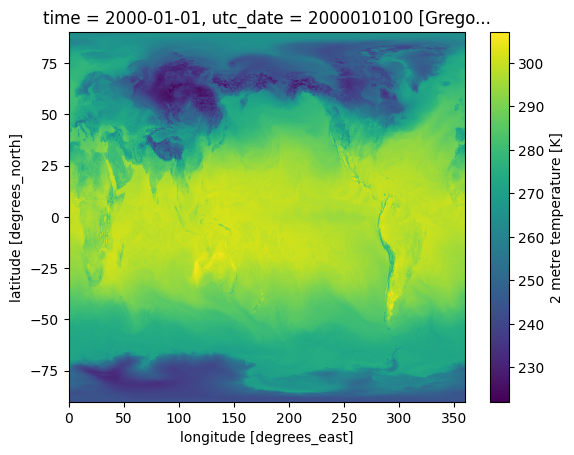

In [15]:
temps.VAR_2T.isel(time=0).plot()

In [16]:
cluster.close()